## PFR Stationary 1 dimension

Plug flow reactor in steady state operation.



In [1]:
import numpy as np

import matplotlib.pyplot as plt

import reactord as rd

from scipy.constants import R


### Operating the PFR

A reactor may be operated in terms of its catalyst operation, thermal operation, 
and pressure operation.


| Catalyst operation | Thermal opration | Pressure operation |
|--------------------|------------------|--------------------|
| Homogeneous        | Isothermal       | Isobaric           |
| Heterogeneous      | Adiabatic        | Non-isobaric       |
|                    | Non-isothermal   |                    |



For the piston flow reactor, the list of implemented operations is:

- Homogeneous  
    - Isothermal  
        - Isobaric
        - Non-isobaric  
    - Adiabatic  
        - Isobaric  
        - Non-isobaric  

#### Reaction rate

Reaction rates are defined by python function with the format:

```python
def reaction_rate(composition: dict, temperature: float, kinetics_constants: dict) -> float:
    # calculation of the reaction rate 
    return evaluated_reaction_rate
```

Composition is the compositional argument of the reaction_rate. The available
compositional arguments in ReactorD are:  

- Concentration $[\frac {mol} {m^3}]$  
- Partial pressure [Pa]

The desired compositional argument is selected in the reactor's definition with
the argument "rates_argument". 

If Concentrationtion is selected as the compositional argument, ReactorD will 
evaluate the ```reaction_rate``` in the concentrations of all the mixture's
substances and the temperature. 
Then, for a hypothetical reaction

$$A + B \rightarrow C $$

the reaction rates could be.

```python
def reaction_rate1(composition, temperature, constants):
    Arr, e, dh = constants["Arrhenius"], constants["activation energy"]

    rate = Arr* np.exp(e / R * (1 / temperature))*composition["A"]*composition["B"]

    return rate
```

### Example: Adiabatic Liquid-Phase Isomerization of Normal Butane
Fogler 6th ed. Example 11.3.

Reaction:

$$Butane + iPentane \leftrightarrow iButane + iPentane $$

Kinetic law:

$$r = k_dC_{But} - k_iC_{i-But}$$

We want to process 163 kmol/h and achieve 70% conversion of n-butane from a mixture 90 mol %
n-butane and 10 mol % i-pentane, which is considered an inert. The feed enters at 330 K

Specific reaction rate at 360K = 31.1  $\ {h^{-1}}$  
Kinetic constant at 60 °C = 3.03  
Enthalpy reaction (dH) = -6900 $\frac {J} {mol n-butane}$  
Activation energy (e)= 65.7 $\frac {kJ} {mol}$    
$C_{p-nBut} = C_{p-iBut}$ = 141 $\frac {J} {mol·K}$  
$C_{p-iPen}$ = 161 $\frac {J} {mol·K}$  
$C_{A0}=9.3$ $\frac {kmol} {mol^3}$ 

Reactor: liquid phase, Adiabatic and isobaric PFR
Pressure not specified. It is assumed as 101325 Pa (pressure will not be 
used)

For convenience the reactor will be import from the modules as pfr

In [9]:
import reactord.flowreactors.stationary_1d.pfr as pfr

__Substance definitions__  

For a liquid phase, adiabatic and isobaric PFR the volume and cp of the pure
substances are necessary to evaluate the balances.

In [10]:
def volume(temperature, pressure):
    f_mol = 163 * 1000 / 3600  # mol / s
    f_volumetric = 100_000 * 0.00378541 / 24 / 3600  # m3 / s

    rho = f_mol / f_volumetric
    v = 1 / rho  # m3 / mol
    return np.full(np.size(temperature), v)

def cp_butane(temperature, pressure):
    return np.full(np.size(temperature), 141)  # J / mol / K

def cp_pentane(temperature, pressure):
    return np.full(np.size(temperature), 161)  # J / mol / K


In [12]:
but = rd.Substance(
    "but", volume_liquid=volume, heat_capacity_liquid=cp_butane
)

ibut = rd.Substance(
    "i-but", volume_liquid=volume, heat_capacity_liquid=cp_butane
)

ipen = rd.Substance(
    "i-pen", volume_liquid=volume, heat_capacity_liquid=cp_pentane
)

__Mixture definition__

In [13]:

mix = rd.mix.IdealSolution([but, ibut, ipen])

In [14]:
kinetic = rd.Kinetic(
    mix=mix,
    reactions={"r1": {"eq": but > ibut, "rate": r_rate, "DH": dh}},
    kinetic_constants={
        "k360": 31.1 / 3600,
        "e": 65.7 * 1000,
        "keq60": 3.03,
        "dh": dh,
    },
    rates_argument="concentration",
)

dh = -6900  # J / mol

f_mol = 163 * 1000 / 3600  # mol / s

__Kinetic definition__  



In [15]:
def r_rate(c, t, cons):
    k360, e, keq60, dh = cons["k360"], cons["e"], cons["keq60"], cons["dh"]

    kd_t = k360 * np.exp(e / R * (1 / 360 - 1 / t))
    keq_t = keq60 * np.exp(dh / R * (1 / (60 + 273.15) - 1 / t))

    rd = kd_t * c["but"]
    ri = kd_t / keq_t * c["i-but"]

    return rd - ri

dh = -6900  # J / mol

__Mass Balance Set__

In [16]:
mb = pfr.mass_balances.MolarFlow(
    molar_flows_in={"but": f_mol * 0.9, "i-but": 0, "i-pen": f_mol * 0.1},
)

__Energy Balance Set__

In [17]:

eb = pfr.energy_balances.Adiabatic(temperature_in_or_out={"in": 330})

__Pressure Balance Set__

In [18]:
pb = pfr.pressure_balances.Isobaric(101325)

__Set and Simulate the reactor__

In [21]:
reactor = pfr.PFR(
    kinetic=kinetic,
    reactor_length=5,
    transversal_area=1,
    grid_size=100,
    mass_balance=mb,
    energy_balance=eb,
    pressure_balance=pb,
)

reactor.simulate(1e-5)

__Ploting results__

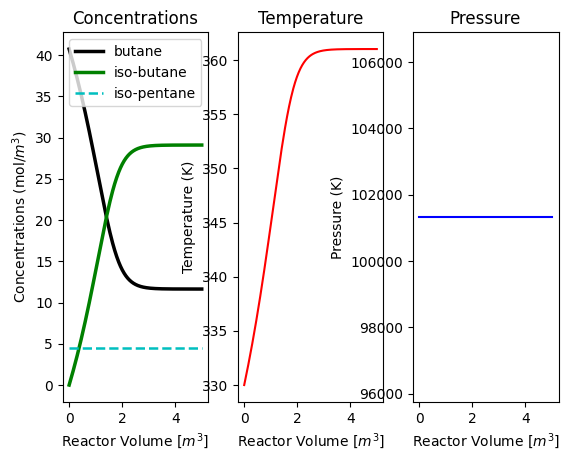

In [23]:
vol_temps = np.array(
    [
        0.11963,
        0.30367,
        0.49701,
        0.6535,
        0.98498,
        1.20608,
        1.42704,
        1.64792,
        1.93304,
        2.54816,
        3.07124,
        3.81441,
        4.47502,
        4.97954,
    ]
)
temps = np.array(
    [
        331.69216,
        334.0963,
        337.03582,
        339.35166,
        344.60768,
        348.61764,
        352.0026,
        355.03043,
        358.14525,
        360.08756,
        360.69388,
        360.9352,
        361.17946,
        360.89359,
    ]
)

vol_x = np.array(
    [
        0.09158,
        0.32051,
        0.57692,
        0.78755,
        0.99817,
        1.26374,
        1.52015,
        1.77656,
        2.28938,
        2.71978,
        3.26923,
    ]
)
x = np.array(
    [
        0.02487,
        0.09767,
        0.18291,
        0.25216,
        0.32674,
        0.43504,
        0.53092,
        0.60551,
        0.68551,
        0.70163,
        0.70892,
    ]
)
rd_temps = reactor.ode_solution.sol(vol_temps)[-2]
rd_fbut = reactor.ode_solution.sol(vol_x)[-0]
rd_x = (f_mol * 0.9 - rd_fbut) / (f_mol * 0.9)


results = reactor.sim_df   

fig1, (ax1, ax2, ax3) = plt.subplots (1,3)

ax1.set_xlabel ("Reactor Volume [$m^{3}$]")
ax1.set_ylabel ("Concentrations (mol/$m^{3}$)")
ax1.set_title ("Concentrations")
ax1.plot (results.z, results["but"], "-k", label="butane", linewidth=2.5)
ax1.plot (results.z, results["i-but"], "-g", label="iso-butane",  linewidth=2.5)
ax1.plot (results.z, results["i-pen"], "--c", label="iso-pentane", linewidth=1.8)
ax1.legend()
         

ax2.set_xlabel ("Reactor Volume [$m^{3}$]")
ax2.set_ylabel ("Temperature (K)")
ax2.set_title ("Temperature")
ax2.plot (results.z, results.temperature, "-r")

ax3.set_xlabel ("Reactor Volume [$m^{3}$]")
ax3.set_ylabel ("Pressure (K)")
ax3.set_title ("Pressure")
ax3.plot (results.z, results.pressure, "-b",)

plt.show()